In [1]:
import pandas as pd

# Sample dataset (small and simple)
data = {
    'CustomerID': [101, 102, 103, 104, 105, 101, 102, 103, 101, 104],
    'InvoiceDate': ['2023-07-01', '2023-07-03', '2023-07-10', '2023-07-20', '2023-07-22',
                    '2023-07-28', '2023-08-01', '2023-08-02', '2023-08-05', '2023-08-10'],
    'Amount': [250, 100, 150, 200, 300, 120, 130, 140, 160, 180]
}

df = pd.DataFrame(data)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()


,CustomerID,InvoiceDate,Amount
0,101,2023-07-01,250
1,102,2023-07-03,100
2,103,2023-07-10,150
3,104,2023-07-20,200
4,105,2023-07-22,300


In [3]:
# Set reference date
today = pd.to_datetime('2023-08-15')

# Group by CustomerID and calculate RFM separately
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': [lambda x: (today - x.max()).days, 'count'],
    'Amount': 'sum'
})

# Fix multi-index columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm.reset_index()

# View result
rfm



,CustomerID,Recency,Frequency,Monetary
0,101,10,3,530
1,102,14,2,230
2,103,13,2,290
3,104,5,2,380
4,105,24,1,300


In [4]:
# Assign RFM scores
rfm['R_Score'] = pd.qcut(rfm['Recency'], 3, labels=[3, 2, 1])       # Lower recency = better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 3, labels=[1, 2, 3])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 3, labels=[1, 2, 3])

# Create an overall RFM segment code
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Simple labels for interpretation
def segment_label(rfm_code):
    if rfm_code == '333':
        return 'Best Customers'
    elif rfm_code.startswith('3'):
        return 'Loyal Customers'
    elif rfm_code.endswith('3'):
        return 'Big Spenders'
    elif rfm_code == '111':
        return 'At Risk'
    else:
        return 'Others'

rfm['Segment'] = rfm['RFM_Segment'].apply(segment_label)

rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'RFM_Segment', 'Segment']]


,CustomerID,Recency,Frequency,Monetary,RFM_Segment,Segment
0,101,10,3,530,333,Best Customers
1,102,14,2,230,111,At Risk
2,103,13,2,290,221,Others
3,104,5,2,380,333,Best Customers
4,105,24,1,300,112,Others


<ipython-input-5-a37cbc6b7de7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='viridis')


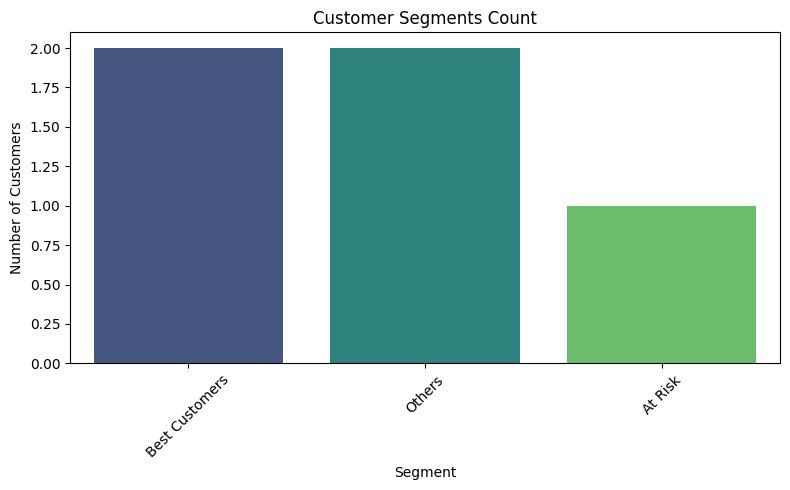

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot of customer segments
plt.figure(figsize=(8, 5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='viridis')
plt.title('Customer Segments Count')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


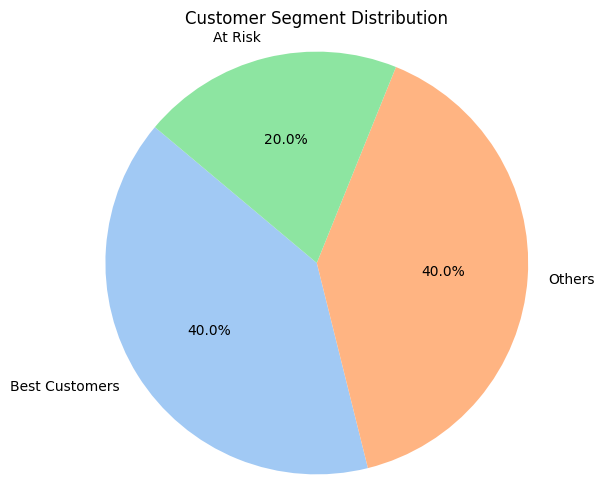

In [6]:
# Pie chart of segments
segment_counts = rfm['Segment'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Customer Segment Distribution')
plt.axis('equal')
plt.show()
